<a href="https://colab.research.google.com/github/leosv123/DATA_CAPTURE/blob/master/Knowledge_Foundry_ML_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
cd My\ Drive

/gdrive/My Drive


## **Import all Packages**

In [217]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

Load the Data of Invoice

In [232]:
data=pd.read_csv('invoice_data.csv')

In [233]:
data.head()

,supplier_id,supplier_name,major_desc,minor_desc,line_item_desc,uom,invoice_desc,category_name
0,84063,Whitco Supply LLC,CAP WKVR CONSTRUCTION INTANGIBLE,MATERIALS/SUPPLIES,6 X .62 GALV NEOP UBOLT W/4NUT,ea,OILFIELD SUPPLIES,Facilities - Equipment
1,3236369,"Nabors Drilling Technologies USA, Inc",8/8 Intangible Drilling Cost,IDC Rig Daywk- Day Rate Land,dayrate/obm rate,NaN,",, ..",Drilling - Day Rate
2,3499225,Basin Supply LP,8/8 Intangible Completion Costs,ICC Site Preparation & Clean Up,*****KIMRAY 250 SOA PBT-D MECH O/W REPAIR KIT ...,each,Invoice Number: 51293198; Lease Name: MCGLOTHL...,Other - Maintenance & Repair
3,220776,MRC Global (US) Inc.,"Pipe, Valves, Fittings","Pipe, Valves, Fittings",10--3 X 1 6000# BLK CS THREDOLET MSS SP97 SA105,ea,"ORDERED BY:RAGEN BAKER, Location: FAUNDA",Facilities - Fittings
4,1106461,"Ft Berthold Services Trucking, LLC",EXPENSE WORKOVERS,TRUCKING & HAULING,FB 148-95-13A-24-3H - Other Fees,each,WETTERHORN 13A PAD / 3H / RIG SERVICES,Needs Review


### **Exploratory Data Analysis**
Check if there are any Null Values in the Data

In [234]:
data.isna().sum()

supplier_id          0
supplier_name        0
major_desc           0
minor_desc           0
line_item_desc       0
uom               4509
invoice_desc         3
category_name        2
dtype: int64

## **Preprocessing Steps:** <br />
a) Remove the Category names having nan, Indeterminate, Needs Review <br />
b) Create a subcategory column from Category Column <br />
c) select top 3 categories and label all other subcategories as Others

In [235]:
#drop the rows with nan,Indeterminate,Needs Review
drop_rowsbytarget=['Indeterminate','Needs Review']
data=data[~data['category_name'].isin(drop_rowsbytarget)]
data.index=range(len(data))

In [236]:
data = data.dropna(subset=['category_name'])

In [237]:
data['sub_category']=data['category_name'].apply(lambda x:x.split('-')[1])
data['category_name']=data['category_name'].apply(lambda x:x.split('-')[0])

In [238]:
top3_subcategories=list(data['sub_category'].value_counts().keys()[:3])

Others        21276
 Fittings      8846
 Equipment     5864
 Day Rate      3555
Name: sub_category, dtype: int64


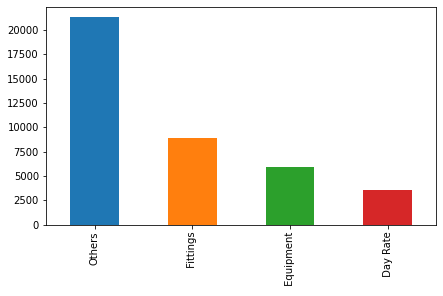

In [239]:
data.loc[~data['sub_category'].isin(top3_subcategories),'sub_category']='Others'
plt.figure(figsize=(7,4))
data['sub_category'].value_counts().plot.bar(color=colors)
print(data['sub_category'].value_counts())

In [240]:
from nltk.corpus import stopwords
import re

In [241]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')


In [242]:
def text_prepare(text):
    """text: a string        
        return: modified initial string"""
    text = text.lower()
    text = re.sub(REPLACE_BY_SPACE_RE,' ',text)
    text = re.sub(BAD_SYMBOLS_RE,'',text)
    return text

Fill the NAN values using a new Value 'NOT KNOWN'

In [243]:
data['uom']=data['uom'].fillna('NOT KNOWN')
data['invoice_desc']=data['invoice_desc'].fillna('NOT KNOWN')

data['invoice_desc'] = [text_prepare(x) for x in data['invoice_desc']]
data['supplier_name'] = [text_prepare(x) for x in data['supplier_name']]
data['major_desc'] = [text_prepare(x) for x in data['major_desc']]
data['minor_desc'] = [text_prepare(x) for x in data['minor_desc']]
data['line_item_desc'] = [text_prepare(x) for x in data['line_item_desc']]
data['category_name'] = [text_prepare(x) for x in data['category_name']]

data.index=range(len(data))

In [244]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
all_cols={key:[] for key in list(data.columns[1:-1])}
for col in list(data.columns[1:-1]):
    for each in range(len(data[col])):
        all_cols[col].append(word_tokenize(data[col][each].lower()))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [245]:
X=pd.DataFrame(all_cols)

### **Feature Engineering** :
Sentence or Phrases embedd using pretrainined BERT MODEL not used

In [246]:
#!pip install sentence_transformers
#from sentence_transformers import SentenceTransformer
#sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

**Sentence Embedding** using Doc2Vec similar Word2Vec having a paragraph vector , done for each of the feature column 

Takes around 20 minutes to train on all the column features

In [248]:
# import
from gensim.models.doc2vec import Doc2Vec, TaggedDocument


#generating standard format for input in feature Word embedding 
tagged_data1 = [TaggedDocument(d, [i]) for i, d in enumerate(X['major_desc'])]
tagged_data2 = [TaggedDocument(d, [i]) for i, d in enumerate(X['minor_desc'])]
tagged_data3 = [TaggedDocument(d, [i]) for i, d in enumerate(X['line_item_desc'])]
tagged_data4 = [TaggedDocument(d, [i]) for i, d in enumerate(X['invoice_desc'])]
tagged_data5 = [TaggedDocument(d, [i]) for i, d in enumerate(X['category_name'])]
tagged_data6 = [TaggedDocument(d, [i]) for i, d in enumerate(X['uom'])]


## Train doc2vec model
model1 = Doc2Vec(tagged_data1, vector_size = 20, window = 2, min_count = 1, epochs = 50)
model2 = Doc2Vec(tagged_data2, vector_size = 20, window = 2, min_count = 1, epochs = 50)
model3 = Doc2Vec(tagged_data3, vector_size = 20, window = 2, min_count = 1, epochs = 50)
model4 = Doc2Vec(tagged_data4, vector_size = 20, window = 2, min_count = 1, epochs = 50)
model5 = Doc2Vec(tagged_data5, vector_size = 20, window = 2, min_count = 1, epochs = 50)
model6 = Doc2Vec(tagged_data6, vector_size = 20, window = 2, min_count = 1, epochs = 50)

Getting the Feature Values for the each columns from the model trained on each column values (i have kept the Vector size of each column value to 20)

Takes around 15Min to get the inference vectors

In [249]:
doc2vec={key:[] for key in list(X.columns)}
for i in list(X.columns):
  for j in range(len(X)):
    if i=='major_desc':
      doc2vec[i].append(model1.infer_vector(X[i][j]))
    elif i=='minor_desc':
      doc2vec[i].append(model2.infer_vector(X[i][j]))
    elif i=='line_item_desc':
      doc2vec[i].append(model3.infer_vector(X[i][j]))
    elif i== 'invoice_desc':
      doc2vec[i].append(model4.infer_vector(X[i][j]))
    elif i== 'category_name':
      doc2vec[i].append(model5.infer_vector(X[i][j]))
    elif i== 'uom':
      doc2vec[i].append(model5.infer_vector(X[i][j]))

Checking if Similar phrase texts or companies have similar Vectors (just sample)

In [253]:
import numpy as np
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

test_doc = word_tokenize("Fittings walves".lower())

print(cosine(model1.infer_vector(' '.join(X['major_desc'][3245])), model1.infer_vector(test_doc)))
print(X['major_desc'][3245])

0.27067477
['well', 'equipment', 'gross']


In [254]:
data['invoice_desc'] = [text_prepare(x) for x in data['invoice_desc']]
data['supplier_name'] = [text_prepare(x) for x in data['supplier_name']]
data['major_desc'] = [text_prepare(x) for x in data['major_desc']]
data['minor_desc'] = [text_prepare(x) for x in data['minor_desc']]
data['line_item_desc'] = [text_prepare(x) for x in data['line_item_desc']]
data['category_name'] = [text_prepare(x) for x in data['category_name']]

data['supplier_name'] = le.fit_transform(data['supplier_name'])
data['major_desc'] = le.fit_transform(data['major_desc'])
data['line_item_desc'] = le.fit_transform(data['line_item_desc'])
data['minor_desc']=le.fit_transform(data['minor_desc'])
data['invoice_desc']=le.fit_transform(data['invoice_desc'])
data['category_name']=le.fit_transform(data['category_name'])
data['sub_category']=le.fit_transform(data['sub_category'])
data['supplier_id']=le.fit_transform(data['supplier_id'])

In [279]:
data.head()

,supplier_id,supplier_name,major_desc,minor_desc,line_item_desc,uom,invoice_desc,category_name,sub_category
0,84063,149,103,1569,11775,ea,22117,2,1
1,3236369,88,15,1079,17177,NOT KNOWN,2,1,0
2,3499225,15,14,941,23702,each,14173,4,3
3,220776,86,970,1872,2509,ea,22898,2,2
4,50582,99,78,1057,18779,NOT KNOWN,25812,1,0


In [280]:
data=data.drop(['uom'],axis=1)

In [295]:
data.head()

,supplier_id,supplier_name,major_desc,minor_desc,line_item_desc,invoice_desc,category_name,sub_category
0,84063,149,103,1569,11775,22117,2,1
1,3236369,88,15,1079,17177,2,1,0
2,3499225,15,14,941,23702,14173,4,3
3,220776,86,970,1872,2509,22898,2,2
4,50582,99,78,1057,18779,25812,1,0


In [296]:
X_enc = data.iloc[:, :-1].values    #   X -> Feature Variables
y_enc = data.iloc[:, -1].values #   y ->  Target

In [282]:
doc2vec['supplier_name']=data['supplier_name']

In [283]:
X=pd.DataFrame(doc2vec)

Contenate all the feature text vectors for each column

In [284]:
all_features=[]
for i in range(len(X)):
  all_features.append(list(X['major_desc'][i])+list(X['minor_desc'][i])+list(X['line_item_desc'][i])+list(X['invoice_desc'][i])+list(X['category_name'][i]))

X['all_features']=all_features

In [285]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['supplier_name']=le.fit_transform(data['supplier_name'])

Create a DataFrame from all the feature vectors as values of columns to train using Machine Learning Models

In [288]:
X_=pd.DataFrame(list(X['all_features']),columns=[i for i in range(100)])
X_['supplier_name']=data['supplier_name']
X_['supplier_id']=le.fit_transform(data['supplier_id'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


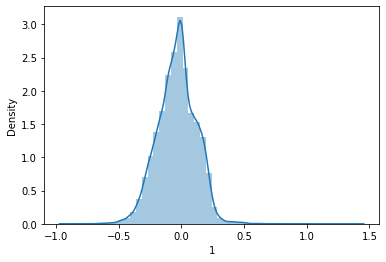

In [340]:
sns.distplot(X_[1])

Finally Label Encode each of the sub categories 

In [289]:
X_.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,supplier_name,supplier_id
0,0.072878,-0.052082,-0.051756,-0.097750,0.286128,0.082810,-0.029057,-0.077223,-0.006241,0.081379,-0.163306,-0.035414,0.029537,0.063750,0.041638,-0.079538,0.023779,0.042539,0.036659,-0.027259,-0.077333,0.083489,0.206387,-0.178902,0.095537,0.008162,0.196301,0.179349,-0.019199,0.352934,0.274210,0.147900,0.099847,-0.229276,-0.060965,0.262937,0.171591,-0.203872,0.216608,-0.108957,...,0.076048,0.049274,0.167440,0.074850,0.177821,0.122467,-0.083317,-0.015384,0.408187,-0.302629,0.126111,-0.103889,-0.136469,0.086511,0.236595,0.031817,0.011116,-0.060124,0.010733,-0.004670,-0.050131,0.026376,-0.008946,0.086060,-0.003050,-0.004584,-0.015357,-0.000255,0.010077,0.016804,-0.011542,-0.000578,0.001076,-0.035285,0.041626,0.002366,-0.012059,-0.012309,149,30
1,0.265168,-0.322212,-0.211836,-0.021066,0.367021,0.311722,-0.020458,-0.200449,-0.478526,0.131897,0.249328,0.051745,-0.167127,0.232878,0.066272,0.263065,0.257665,-0.117953,0.112387,-0.068805,-0.110899,0.001587,0.029508,-0.186098,-0.024972,-0.031370,-0.085034,0.028444,-0.001659,-0.009467,0.173206,-0.022068,-0.190762,0.124903,-0.125766,0.246190,0.339499,-0.197761,-0.028406,0.042339,...,0.005138,0.002244,-0.003817,0.007295,-0.003121,0.019589,0.023183,-0.005828,0.014586,0.001445,0.003402,0.021280,-0.021448,-0.020644,-0.023989,0.016631,0.013908,0.018501,0.027243,0.104084,0.058371,-0.012737,0.061608,-0.115065,0.041933,0.087596,0.031319,0.080817,0.008197,-0.019207,0.095630,-0.006551,0.134298,0.105498,-0.028298,-0.027152,-0.062458,-0.014073,88,129
2,0.212873,-0.186214,-0.260628,-0.135219,0.233603,0.369794,0.175724,-0.144844,-0.349736,0.233033,0.151318,0.358347,-0.163591,0.208195,0.036416,-0.013559,-0.072698,-0.237191,0.011155,-0.314837,-0.143982,-0.123889,0.280497,-0.075646,0.265248,-0.251149,0.031513,-0.148816,-0.123889,-0.406723,0.304222,-0.057928,0.050042,-0.167540,-0.401235,0.017077,0.279147,-0.260205,-0.116520,0.008045,...,0.039802,-0.208597,0.167791,0.126859,0.302344,0.451598,-0.463357,0.105344,1.057811,-0.899166,0.341842,-0.077316,-0.551878,0.114892,0.113531,0.517025,-0.015642,-0.017487,0.062342,0.144559,0.079507,0.062341,0.116162,-0.130307,0.027626,0.105554,-0.061141,0.089645,-0.002860,-0.000225,0.058922,-0.006130,0.178196,-0.010776,0.000960,-0.147337,-0.058872,-0.116021,15,138
3,0.092821,0.039031,0.029245,0.021835,0.091515,-0.111870,0.037881,0.216360,-0.116988,-0.048318,-0.077899,-0.011028,-0.038614,0.047344,-0.213318,0.177913,0.087386,-0.007606,-0.041923,-0.252749,-0.107809,0.269286,0.091258,0.005812,0.097407,0.038618,-0.060686,0.250509,-0.242191,-0.087537,-0.065138,-0.091235,-0.140831,-0.054208,-0.246053,0.318047,0.141278,-0.066662,-0.080681,-0.279193,...,-0.265399,-0.462603,0.191484,-0.166169,0.444076,0.310977,-0.086395,0.361037,0.810358,-0.239002,0.581127,-0.267537,-0.269263,0.140751,-0.093506,-0.178973,-0.379500,-0.127409,0.018592,-0.012231,-0.110649,0.006636,-0.032338,0.146539,-0.042890,0.017258,-0.048137,-0.012774,0.019834,0.008514,-0.044092,0.006805,-0.029272,-0.061291,0.102127,-0.017925,-0.013290,0.039280,86,38
4,0.052131,-0.017056,0.009880,-0.054462,0.020741,-0.069678,0.010885,0.044112,-0.005272,-0.022383,0.025398,0.103287,0.019591,0.009187,-0.047217,0.039109,0.073606,-0.012412,0.064411,-0.043681,-0.399159,-0.229562,-0.074363,0.127075,0.166350,-0.151894,0.158314,0.432090,-0.086021,-0.011977,0.233250,-0.357950,-0.472777,-0.006674,0.037002,-0.028714,0.022610,-0.131608,-0.313285,0.131207,...,-0.218044,0.103340,-0.134080,0.246568,0.184984,0.055322,-0.835610,-0.360940,0.740141,-0.249497,0.512799,0.198544,0.294034,0.219674,0.121769,0.581432,-0.316997,0.076542,0.074049,0.226854,0.116851,0.030777,0.152172,-0.246379,0.054444,0.183806,-0.029687,0.153966,0.015468,-0.048702,0.155180,-0.011895,0.310228,0.124344,-0.055036,-0.134355,-0.098010,-0

**Model is tested using models:** <br />
As the Target Variables are imbalanced a cost sensitive balanced Decision Tree is used. 

a) **Decision Tree** <br />

Sampling of data is done while training Light Gradient Boost <br />
b) **LGBM with Nested Cross Validation to select the best parameters**

In [297]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy import stats
import pylab as pl
X_train, X_test, y_train, y_test = train_test_split(X_,data['sub_category'] , test_size = 0.3, random_state = 0)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc,y_enc , test_size = 0.3, random_state = 0)

In [309]:
from sklearn.tree import DecisionTreeClassifier


def DecisionTreeModel(X_train,y_train,X_test,y_test):
      ''' 
      parameters deafult used 
      for the predictions
      '''
  Model = DecisionTreeClassifier(class_weight='balanced')

  Model.fit(X_train, y_train)

  y_pred1 = Model.predict(X_test)

  importance = Model.feature_importances_
  plt.figure(figsize=(15,5))
  sns.barplot([x for x in range(len(importance))], importance)


  print(classification_report(y_test, y_pred1))
  #print(confusion_matrix(y_test, y_pred1))
  # Accuracy score
  print('accuracy is',accuracy_score(y_pred1,y_test))

Decision Tree Model Interpretation showing that the Category Features is more important and features like  supplier_id,supplier_name, minor_desc, features also playing a role in predicting the Sub Categories 

---



============Text Embedding Word2Vec RESULTS====================


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


              precision    recall  f1-score   support

           0       0.88      0.87      0.88      1048
           1       0.48      0.46      0.47      1793
           2       0.65      0.64      0.64      2758
           3       0.84      0.86      0.85      6264

    accuracy                           0.75     11863
   macro avg       0.71      0.71      0.71     11863
weighted avg       0.74      0.75      0.75     11863

accuracy is 0.7470285762454691
============LABEL ENCODING RESULTS====================
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1048
           1       0.76      0.73      0.75      1793
           2       0.83      0.83      0.83      2758
           3       0.93      0.94      0.94      6264

    accuracy                           0.89     11863
   macro avg       0.88      0.87      0.88     11863
weighted avg       0.89      0.89      0.89     11863

accuracy is 0.8885610722414229


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


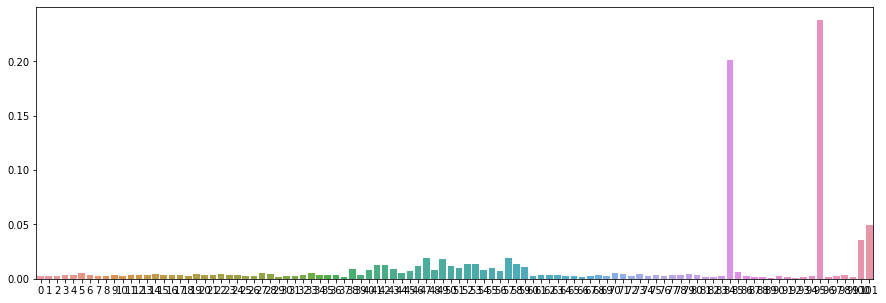

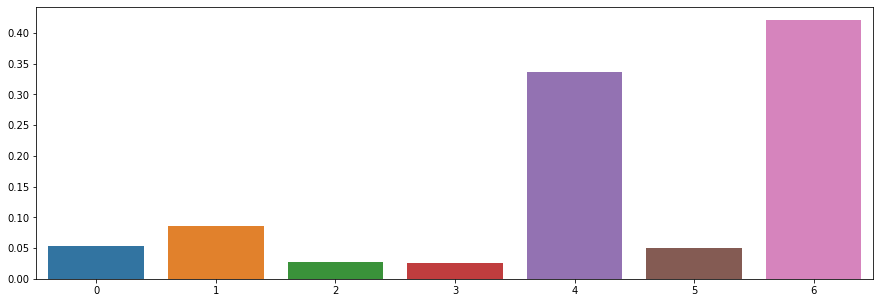

In [310]:
print("============Text Embedding Word2Vec RESULTS====================")
DecisionTreeModel(X_train,y_train,X_test,y_test)
print("============LABEL ENCODING RESULTS====================")
DecisionTreeModel(X_train_enc,y_train_enc,X_test_enc,y_test_enc)

print("============LABEL ENCODING RESULTS with uom====================")
DecisionTreeModel(X_train_enc,y_train_enc,X_test_enc,y_test_enc)

In [293]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB
Model = GaussianNB()
Model.fit(X_train, y_train)

y_pred1 = Model.predict(X_test)

# Summary of the predictions made by the classifier
print(classification_report(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
# Accuracy score
print('accuracy is',accuracy_score(y_pred1,y_test))

              precision    recall  f1-score   support

           0       0.55      0.94      0.70      1048
           1       0.26      0.10      0.14      1793
           2       0.52      0.92      0.66      2758
           3       0.94      0.68      0.79      6264

    accuracy                           0.67     11863
   macro avg       0.57      0.66      0.57     11863
weighted avg       0.71      0.67      0.65     11863

[[ 989   17    0   42]
 [ 231  181 1211  170]
 [   0  178 2533   47]
 [ 566  329 1119 4250]]
accuracy is 0.6704037764477788


In [311]:
import lightgbm as lgb #LGB
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [312]:
models_to_run = [lgb.LGBMClassifier()]

In [318]:
params=[{'learning_rate': [0.15],
         'n_estimators': [30],
         'reg_alpha' : [0.5],
         'reg_lambda' : [1],
         'subsample': [0.8],
        'alpha':[0.5]
         }]

In [314]:
!pip install nested_cv
from sklearn.model_selection import GridSearchCV, KFold
from nested_cv import NestedCV

In [325]:
def LGBModel(X_train,y_train):
  NUM_TRIALS=1
  LGB_scores = []
  

  for trial in range(NUM_TRIALS):
      print('TRIAL NUMBER: ', trial+1)
      for i,model in enumerate(models_to_run):
          nested_CV_search = NestedCV(model=model, params_grid=params[i], outer_kfolds=5, 
                                    inner_kfolds=5, cv_options={'sqrt_of_score':True,'randomized_search_iter':30})
          nested_CV_search.fit(X=X_train,y=y_train)
          model_param_grid = nested_CV_search.best_params
          print('\nCumulated best parameter grids was:\n{0}'.format(model_param_grid))

          gscv = GridSearchCV(estimator=model, param_grid=model_param_grid, scoring='neg_mean_squared_error', cv=5)
          gscv.fit(X_train,y_train)

          print('\nFitting with optimal parameters:\n{0}'.format(gscv.best_params_))
          return(gscv)

In [327]:
print("========LGB on Embedding Text Features==========")
gscv1=LGBModel(X_train,y_train)
y_pred=gscv1.predict(X_test)
print('accuracy is',accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))
print("========LGB on Label Encoded Features==========")
gscv2=LGBModel(X_train_enc,y_train_enc)
y_pred_enc=gscv2.predict(X_test_enc)
print('accuracy is',accuracy_score(y_test_enc,y_pred_enc))
print(classification_report(y_test, y_pred_enc))

========LGB on Embedding Text Features==========
TRIAL NUMBER:  1

Cumulated best parameter grids was:
{'alpha': [0.5], 'learning_rate': [0.15], 'n_estimators': [30], 'reg_alpha': [0.5], 'reg_lambda': [1], 'subsample': [0.8]}

Fitting with optimal parameters:
{'alpha': 0.5, 'learning_rate': 0.15, 'n_estimators': 30, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.8}
accuracy is 0.8349490010958442
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1048
           1       0.72      0.46      0.56      1793
           2       0.70      0.89      0.79      2758
           3       0.92      0.90      0.91      6264

    accuracy                           0.83     11863
   macro avg       0.81      0.80      0.80     11863
weighted avg       0.84      0.83      0.83     11863

========LGB on Label Encoded Features==========
TRIAL NUMBER:  1

Cumulated best parameter grids was:
{'alpha': [0.5], 'learning_rate': [0.15], 'n_estimators': [30

## **Final Inferences and Saving the Model:**
a) **Features like uom** is highly variant, contains lots of NULL values and disturbant to the model performance as the recall of the class of Equipment sub category is almost zero when feature is considered.<br />

b) The **target class were varying** (imbalanced), so the cost sensitive Model with weight balancing is used to avoid overfitting a particular class. <br />  

c) As the **supplier id, supplier name , supplier category** is important and correct in human sense feature showing that the interpretability predictions are not biased to the particular sub category (target class). <br />

d)  The parameters chosen for building the Models is selected using Nested Cross Validation on 5 kfold. **Model** with features of Encoding performs well or better than the embedded features getting an accuracy of 87% by LightGBM and 89% by the Decision trees.

 



In [331]:
import pickle
pkl_filename1 = "LGB_model_emb.pkl"
pkl_filename2 = "LGB_model_enc.pkl"

with open(pkl_filename1, 'wb') as file:
    pickle.dump(gscv1, file)

with open(pkl_filename2, 'wb') as file:
    pickle.dump(gscv2, file)

In [332]:
with open(pkl_filename1, 'rb') as file:
    pickle_model = pickle.load(file)

In [333]:
pickle_model.predict(X_test)

array([3, 3, 1, ..., 3, 2, 3])

In [342]:
pd.DataFrame(y).value_counts()

3    21276
2     8846
1     5864
0     3555
dtype: int64